# Stochastic Modeling for Financial Risk

This project demonstrates simulation and modeling of financial risk using stochastic processes. The main techniques include:
- Geometric Brownian Motion (GBM)
- Student-t distribution for fat-tailed returns
- Value at Risk (VaR) estimation
- Rolling volatility models
- Model validation using backtesting, QQ plots, and statistical fit tests

We apply these models to SPY (S&P 500 ETF) data and a multi-asset portfolio, comparing simulated results to historical market behavior.

## 1. Assumptions and Theoretical Foundations

The following assumptions are made:
- Asset prices follow a Geometric Brownian Motion under the risk-neutral measure
- Log returns are fat-tailed and may be better modeled with a Student-t distribution
- VaR is evaluated at a 5% confidence level, using both historical and parametric approaches
- Backtesting is done with a 60-day rolling window
- Multi-asset portfolio returns are simulated assuming log-normal dynamics and static equal weights

## 2. Methodology

We implement and evaluate the following steps:
1. Simulate GBM returns and compare to SPY
2. Fit a Student-t distribution to log returns
3. Estimate Value at Risk using historical, normal, and Student-t methods
4. Perform rolling volatility analysis
5. Backtest VaR forecasts against actual returns
6. Construct a multi-asset portfolio (SPY, TLT, QQQ, GLD) and simulate its performance
7. Use QQ plots, K-S test, and AIC/BIC for model comparison

In [3]:
#Initial Simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting settings
sns.set(style="darkgrid")
%matplotlib inline

In [4]:
# Simulation settings
T = 1.0            # time horizon (in years)
dt = 1/252         # daily steps (252 trading days/year)
N = int(T / dt)    # number of time steps
n_sim = 1000       # number of simulations

# Asset parameters
S0 = 100           # initial price
mu = 0.08          # expected annual return
sigma = 0.2        # annual volatility


In [5]:
def simulate_gbm(S0, mu, sigma, T, dt, n_sim):
    N = int(T / dt)
    S = np.zeros((N, n_sim))
    S[0] = S0
    for t in range(1, N):
        Z = np.random.standard_normal(n_sim)
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    return S

In [6]:
simulated_paths = simulate_gbm(S0, mu, sigma, T, dt, n_sim)

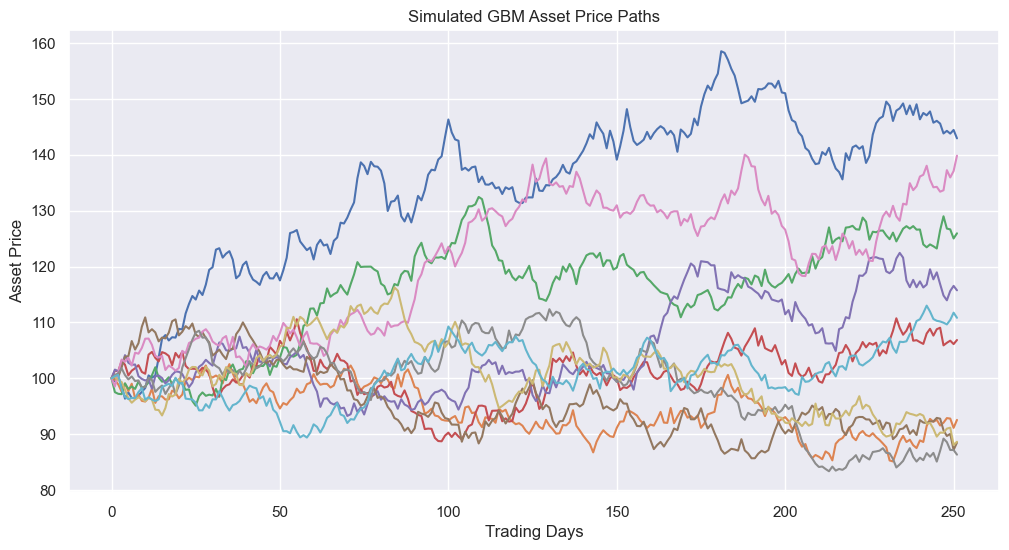

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(simulated_paths[:, :10])  # plot first 10 paths
plt.title("Simulated GBM Asset Price Paths")
plt.xlabel("Trading Days")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

In [8]:
# Final simulated prices
final_prices = simulated_paths[-1, :]

# Risk metrics
confidence_level = 0.95
VaR = np.percentile(final_prices, (1 - confidence_level) * 100)
CVaR = final_prices[final_prices <= VaR].mean()

# Print results
print(f"Value at Risk (5%): ${S0 - VaR:.2f}")
print(f"Conditional VaR (CVaR): ${S0 - CVaR:.2f}")

Value at Risk (5%): $23.30
Conditional VaR (CVaR): $28.13


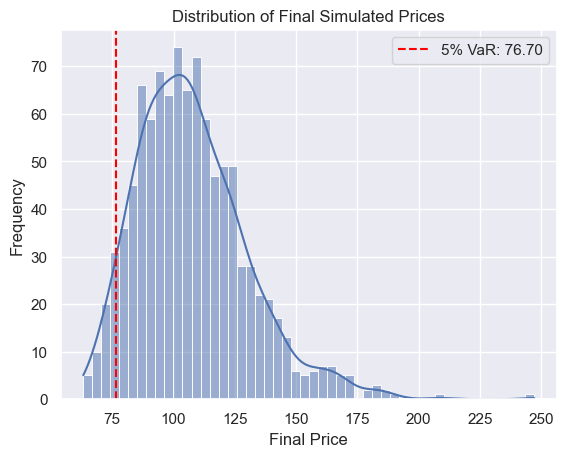

In [9]:
sns.histplot(final_prices, kde=True, bins=50)
plt.axvline(VaR, color='red', linestyle='--', label=f'5% VaR: {VaR:.2f}')
plt.title("Distribution of Final Simulated Prices")
plt.xlabel("Final Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [10]:
#Sensitivity analysis
mu_values = [0.02, 0.05, 0.08, 0.10, 0.12]      # Drift from 2% to 12%
sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]        # Volatility from 10% to 50%

In [11]:
def simulate_var_cvar(S0, mu, sigma, T, dt, n_sim, alpha=0.95):
    prices = simulate_gbm(S0, mu, sigma, T, dt, n_sim)
    final_prices = prices[-1, :]
    var = np.percentile(final_prices, (1 - alpha) * 100)
    cvar = final_prices[final_prices <= var].mean()
    return var, cvar

In [12]:
results = []

for mu in mu_values:
    for sigma in sigma_values:
        var, cvar = simulate_var_cvar(S0=100, mu=mu, sigma=sigma, T=1.0, dt=1/252, n_sim=1000)
        results.append({
            'mu': mu,
            'sigma': sigma,
            'VaR (95%)': 100 - var,
            'CVaR (95%)': 100 - cvar
        })

df_results = pd.DataFrame(results)

In [13]:
df_results.sort_values(by='sigma').head()

,mu,sigma,VaR (95%),CVaR (95%)
0,0.02,0.1,13.953614,16.930674
20,0.12,0.1,4.616413,8.317626
5,0.05,0.1,10.493790,13.604802
15,0.10,0.1,6.559381,9.929870
10,0.08,0.1,8.059924,12.632512


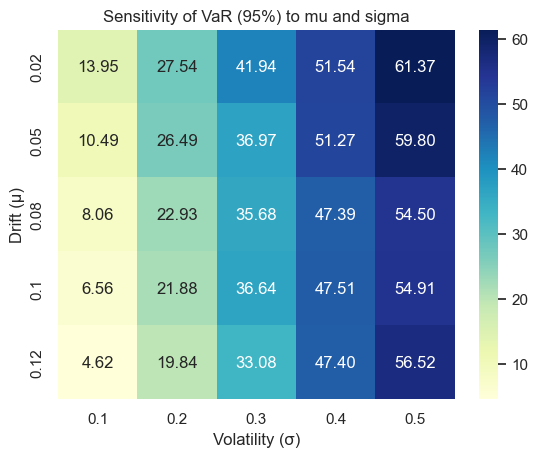

In [14]:
pivot_var = df_results.pivot(index='mu', columns='sigma', values='VaR (95%)')

sns.heatmap(pivot_var, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Sensitivity of VaR (95%) to mu and sigma")
plt.xlabel("Volatility (σ)")
plt.ylabel("Drift (μ)")
plt.show()

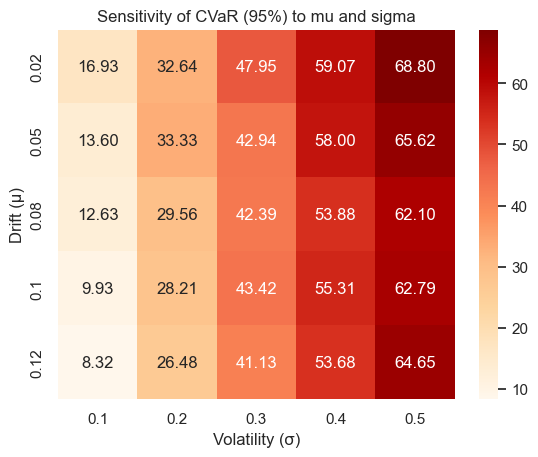

In [15]:
pivot_cvar = df_results.pivot(index='mu', columns='sigma', values='CVaR (95%)')

sns.heatmap(pivot_cvar, annot=True, cmap="OrRd", fmt=".2f")
plt.title("Sensitivity of CVaR (95%) to mu and sigma")
plt.xlabel("Volatility (σ)")
plt.ylabel("Drift (μ)")
plt.show()

In [16]:
#Simulating Fat-tailed distributions
def simulate_fat_tailed_gbm(S0, mu, sigma, T, dt, n_sim, df):
    N = int(T / dt)
    S = np.zeros((N, n_sim))
    S[0] = S0
    for t in range(1, N):
        Z = np.random.standard_t(df, size=n_sim)
        Z = Z * np.sqrt((df - 2) / df)  # scale to unit variance
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

In [17]:
S0 = 100
mu = 0.08
sigma = 0.2
T = 1.0
dt = 1/252
n_sim = 1000
df = 3  # degrees of freedom — fat tails

fat_paths = simulate_fat_tailed_gbm(S0, mu, sigma, T, dt, n_sim, df)

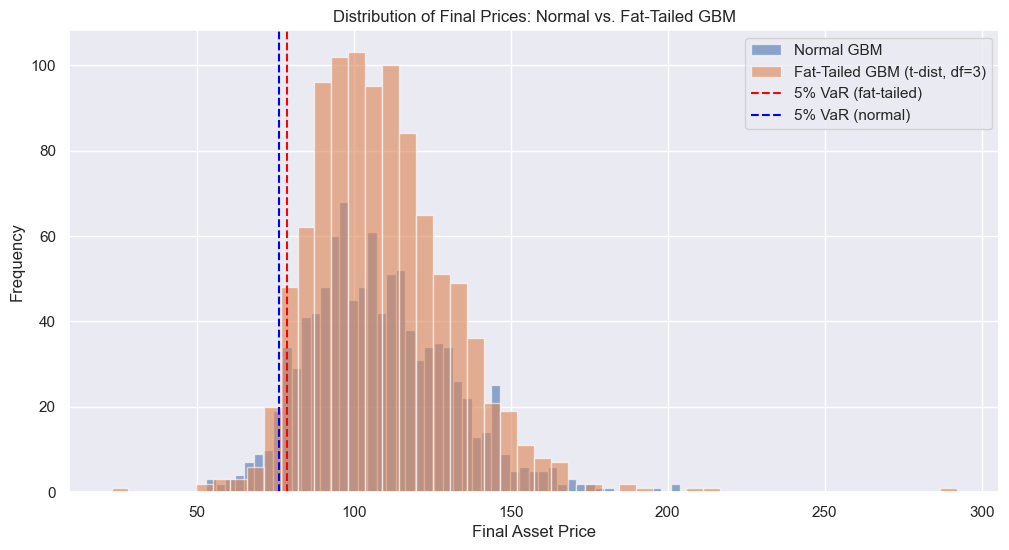

In [18]:
normal_paths = simulate_gbm(S0, mu, sigma, T, dt, n_sim)

plt.figure(figsize=(12, 6))
plt.hist(normal_paths[-1], bins=50, alpha=0.6, label='Normal GBM')
plt.hist(fat_paths[-1], bins=50, alpha=0.6, label='Fat-Tailed GBM (t-dist, df=3)')
plt.axvline(np.percentile(fat_paths[-1], 5), color='red', linestyle='--', label='5% VaR (fat-tailed)')
plt.axvline(np.percentile(normal_paths[-1], 5), color='blue', linestyle='--', label='5% VaR (normal)')
plt.title("Distribution of Final Prices: Normal vs. Fat-Tailed GBM")
plt.xlabel("Final Asset Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [19]:
def compute_risk_metrics(prices, alpha=0.95):
    VaR = np.percentile(prices, (1 - alpha) * 100)
    CVaR = prices[prices <= VaR].mean()
    return VaR, CVaR

var_normal, cvar_normal = compute_risk_metrics(normal_paths[-1])
var_fat, cvar_fat = compute_risk_metrics(fat_paths[-1])

print(f"Normal GBM VaR (5%): ${S0 - var_normal:.2f}")
print(f"Normal GBM CVaR: ${S0 - cvar_normal:.2f}")
print(f"Fat-Tailed GBM VaR (5%): ${S0 - var_fat:.2f}")
print(f"Fat-Tailed GBM CVaR: ${S0 - cvar_fat:.2f}")

Normal GBM VaR (5%): $23.80
Normal GBM CVaR: $31.12
Fat-Tailed GBM VaR (5%): $21.19
Fat-Tailed GBM CVaR: $28.54


In [20]:
#Comparison to real-world data
!pip install yfinance --quiet

In [21]:
import yfinance as yf

# Get adjusted close prices safely
data = yf.download("SPY", start="2015-01-01", end="2024-01-01")
spy = data['Close']  # Already adjusted if auto_adjust=True

/var/folders/86/gfyk82kj2n1cn5x1_mgm5mpw0000gn/T/ipykernel_7903/1820855969.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2015-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [22]:
log_returns_spy = np.log(spy / spy.shift(1)).dropna()

In [23]:
# Simulate normal GBM and fat-tailed GBM
sim_gbm = simulate_gbm(S0=100, mu=0.08, sigma=0.2, T=1.0, dt=1/252, n_sim=1000)
sim_fat = simulate_fat_tailed_gbm(S0=100, mu=0.08, sigma=0.2, T=1.0, dt=1/252, n_sim=1000, df=3)

# Convert to daily log returns
log_returns_gbm = np.log(sim_gbm[1:] / sim_gbm[:-1]).flatten()
log_returns_fat = np.log(sim_fat[1:] / sim_fat[:-1]).flatten()

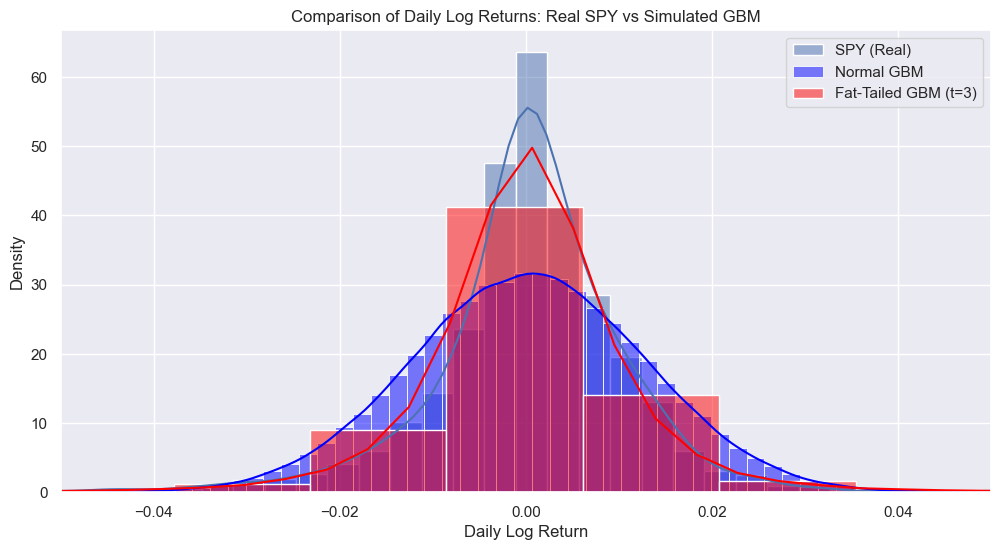

In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(log_returns_spy, bins=60, color="black", label="SPY (Real)", kde=True, stat="density")
sns.histplot(log_returns_gbm, bins=60, color="blue", label="Normal GBM", kde=True, stat="density", alpha=0.5)
sns.histplot(log_returns_fat, bins=60, color="red", label="Fat-Tailed GBM (t=3)", kde=True, stat="density", alpha=0.5)

plt.title("Comparison of Daily Log Returns: Real SPY vs Simulated GBM")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.xlim([-0.05, 0.05])  # Focus on -5% to +5% daily returns
plt.show()

In [25]:
from scipy.stats import kurtosis

print("Kurtosis (Real SPY):", kurtosis(log_returns_spy))
print("Kurtosis (Normal GBM):", kurtosis(log_returns_gbm))
print("Kurtosis (Fat-Tailed GBM):", kurtosis(log_returns_fat))

# Frequency of returns below -2%
print("\nP(R < -2%)")
print("SPY:", np.mean(log_returns_spy < -0.02))
print("Normal GBM:", np.mean(log_returns_gbm < -0.02))
print("Fat-Tailed GBM:", np.mean(log_returns_fat < -0.02))

Kurtosis (Real SPY): [13.47780552]
Kurtosis (Normal GBM): -0.010232519744755919
Kurtosis (Fat-Tailed GBM): 53.58692458301695

P(R < -2%)
SPY: 0.037560760053026956
Normal GBM: 0.05400796812749004
Fat-Tailed GBM: 0.03463745019920319


In [26]:
#Merton Model with Poisson Distributed Jumps
def simulate_jump_diffusion(
    S0=100, mu=0.1, sigma=0.2,
    lamb=0.3, mu_j=-0.02, sigma_j=0.05,
    T=1.0, dt=1/252, n_sim=1000
):
    n_steps = int(T / dt)
    S = np.zeros((n_steps, n_sim))
    S[0] = S0

    kappa = np.exp(mu_j + 0.5 * sigma_j**2) - 1  # jump correction

    for t in range(1, n_steps):
        Z = np.random.normal(size=n_sim)
        N = np.random.poisson(lamb * dt, size=n_sim)
        Y = np.random.normal(mu_j, sigma_j, size=n_sim) * N

        drift = (mu - 0.5 * sigma**2 - lamb * kappa) * dt
        diffusion = sigma * np.sqrt(dt) * Z
        jump_component = Y

        S[t] = S[t-1] * np.exp(drift + diffusion + jump_component)

    return S

In [27]:
S0 = 100
mu = 0.08
sigma = 0.2
T = 1
dt = 1/252
n_sim = 1000

S_jump = simulate_jump_diffusion(S0, mu, sigma, lamb=0.3, mu_j=-0.02, sigma_j=0.05, T=T, dt=dt, n_sim=n_sim)

In [28]:
log_returns_jump = np.log(S_jump[1:] / S_jump[:-1]).flatten()

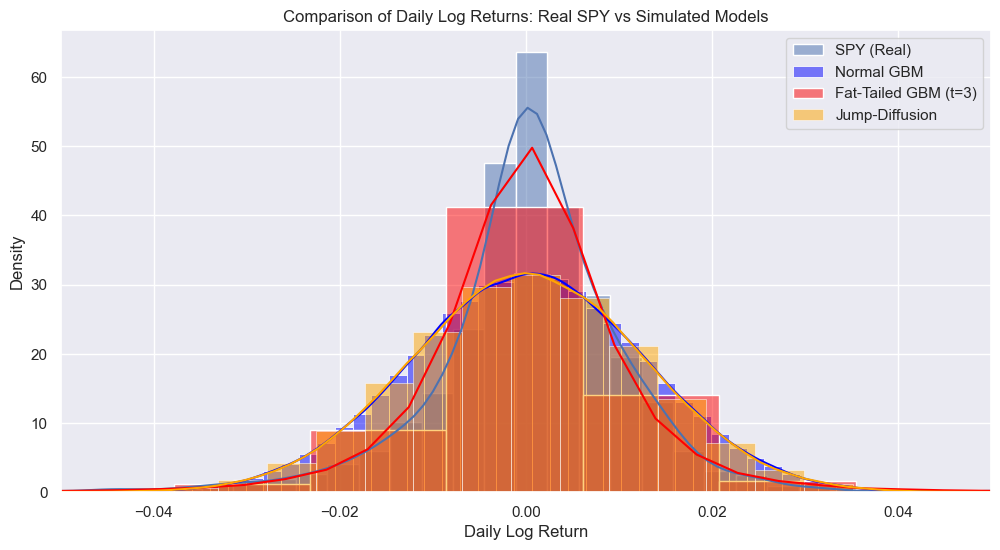

In [29]:
plt.figure(figsize=(12, 6))

sns.histplot(log_returns_spy, bins=60, color="black", label="SPY (Real)", kde=True, stat="density")
sns.histplot(log_returns_gbm, bins=60, color="blue", label="Normal GBM", kde=True, stat="density", alpha=0.5)
sns.histplot(log_returns_fat, bins=60, color="red", label="Fat-Tailed GBM (t=3)", kde=True, stat="density", alpha=0.5)
sns.histplot(log_returns_jump, bins=60, color="orange", label="Jump-Diffusion", kde=True, stat="density", alpha=0.5)

plt.title("Comparison of Daily Log Returns: Real SPY vs Simulated Models")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.xlim([-0.05, 0.05])
plt.show()

In [30]:
#Model Evaluation
import scipy.stats as stats
df_hat, loc_hat, scale_hat = stats.t.fit(log_returns_spy)
print(f"Fitted Student-t: df = {df_hat:.2f}, loc = {loc_hat:.4f}, scale = {scale_hat:.4f}")

Fitted Student-t: df = 2.62, loc = 0.0008, scale = 0.0065


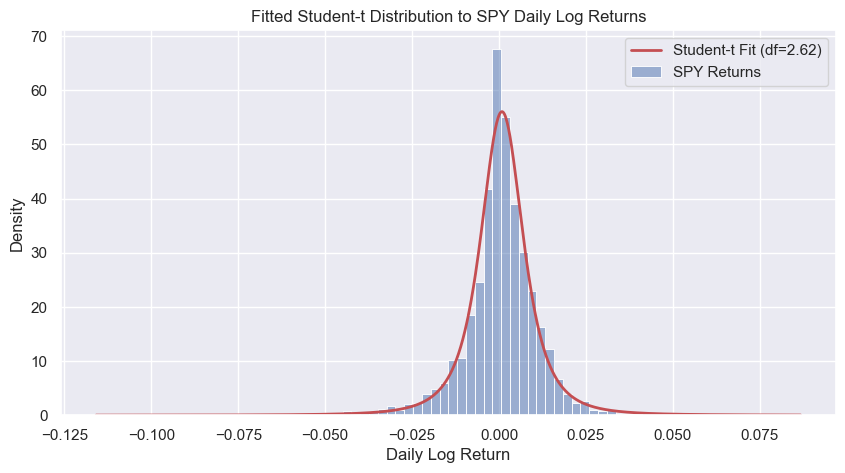

In [31]:
x = np.linspace(log_returns_spy.min(), log_returns_spy.max(), 1000)
pdf_t = stats.t.pdf(x, df_hat, loc=loc_hat, scale=scale_hat)

plt.figure(figsize=(10, 5))
sns.histplot(log_returns_spy, bins=80, stat='density', kde=False, color='gray', label='SPY Returns')
plt.plot(x, pdf_t, 'r-', lw=2, label=f'Student-t Fit (df={df_hat:.2f})')
plt.title('Fitted Student-t Distribution to SPY Daily Log Returns')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
#Implementing Rolling Risk Metrics
window = 20

# Rolling annualized volatility
rolling_vol = log_returns_spy.rolling(window).std() * np.sqrt(252)

# 5% Rolling Value-at-Risk
rolling_var = log_returns_spy.rolling(window).quantile(0.05)

# 5% Rolling Conditional VaR (expected shortfall below 5% quantile)
rolling_cvar = log_returns_spy.rolling(window).apply(
    lambda x: x[x <= x.quantile(0.05)].mean(), raw=False
)

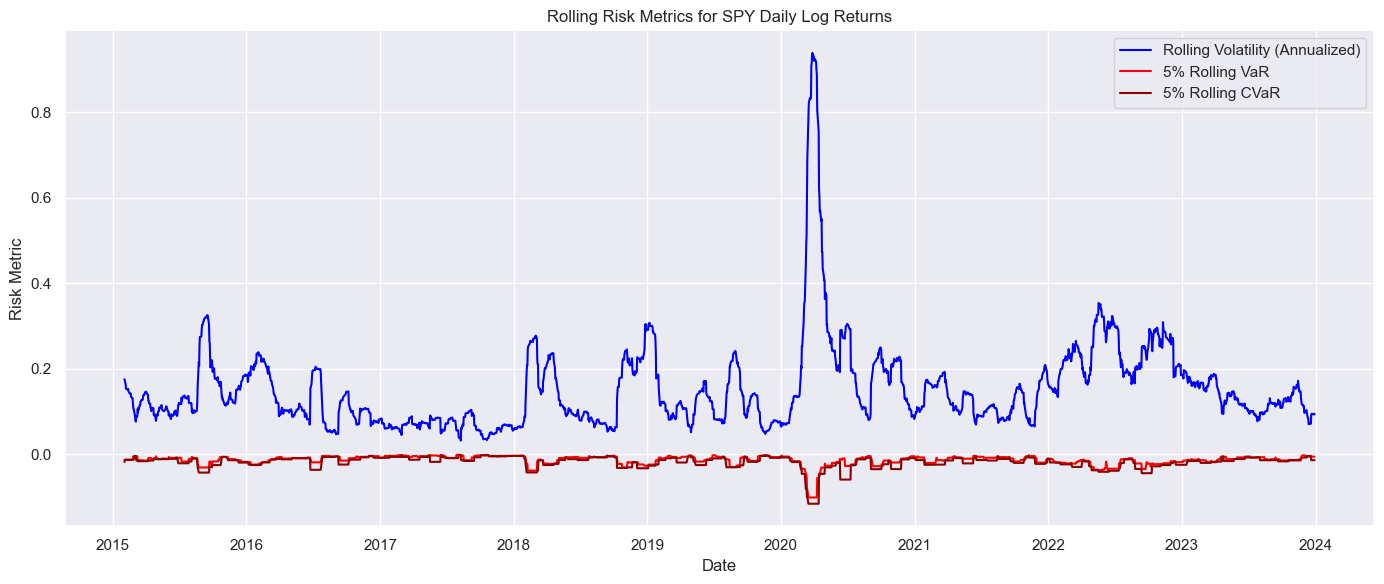

In [33]:
plt.figure(figsize=(14, 6))

plt.plot(rolling_vol, label='Rolling Volatility (Annualized)', color='blue')
plt.plot(rolling_var, label='5% Rolling VaR', color='red')
plt.plot(rolling_cvar, label='5% Rolling CVaR', color='darkred')

plt.title('Rolling Risk Metrics for SPY Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Risk Metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
#Multi-asset portfolio simulation
tickers = ["SPY", "TLT", "GLD", "QQQ"]
data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Close']  # or use 'Adj Close' with auto_adjust=False
log_returns = np.log(data / data.shift(1)).dropna()

/var/folders/86/gfyk82kj2n1cn5x1_mgm5mpw0000gn/T/ipykernel_7903/2991097036.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Close']  # or use 'Adj Close' with auto_adjust=False
[*********************100%***********************]  4 of 4 completed


In [35]:
mu = log_returns.mean()       # vector of mean returns
cov = log_returns.cov()       # covariance matrix of returns

In [36]:
n_simulations = 10_000
simulated_returns = np.random.multivariate_normal(mu, cov, size=n_simulations)

In [37]:
weights = np.array([0.25, 0.25, 0.25, 0.25])  # equal weights
portfolio_returns = simulated_returns @ weights

In [38]:
VaR_5 = np.percentile(portfolio_returns, 5)
print(f"5% 1-day VaR: {VaR_5:.4f}")

5% 1-day VaR: -0.0125


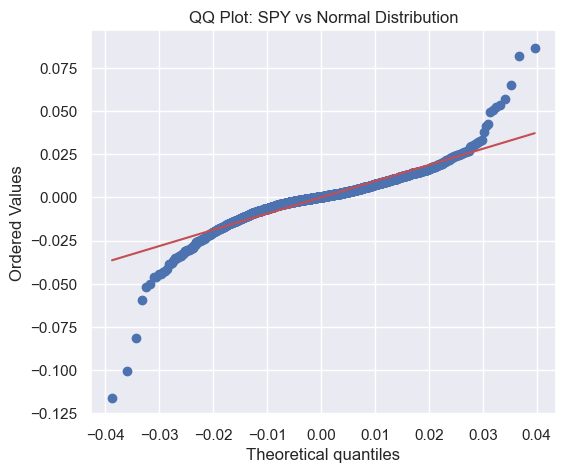

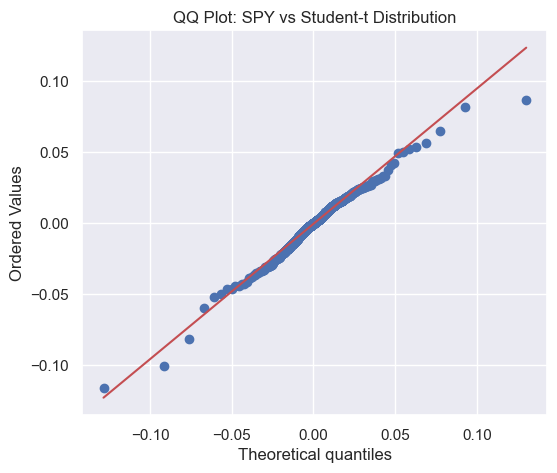

In [40]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Ensure log_returns_spy is a 1D Series
returns = log_returns_spy.squeeze().dropna()

# --- QQ Plot: SPY vs Normal Distribution ---
mu_norm, std_norm = returns.mean(), returns.std()

plt.figure(figsize=(6, 5))
stats.probplot(returns, dist="norm", sparams=(mu_norm, std_norm), plot=plt)
plt.title("QQ Plot: SPY vs Normal Distribution")
plt.grid(True)
plt.show()

# --- QQ Plot: SPY vs Student-t Distribution ---
df_t, loc_t, scale_t = stats.t.fit(returns)

plt.figure(figsize=(6, 5))
stats.probplot(returns, dist="t", sparams=(df_t, loc_t, scale_t), plot=plt)
plt.title("QQ Plot: SPY vs Student-t Distribution")
plt.grid(True)
plt.show()

In [47]:
from scipy.stats import norm, t
import numpy as np

# Ensure 1D array of returns
returns = log_returns_spy.squeeze().dropna().values
n = len(returns)

# --- Fit Normal Distribution ---
mu_norm, std_norm = returns.mean(), returns.std()
ll_normal = np.sum(norm.logpdf(returns, loc=mu_norm, scale=std_norm))
aic_normal = 2 * 2 - 2 * ll_normal  # 2 params: mu and sigma
bic_normal = np.log(n) * 2 - 2 * ll_normal

# --- Fit Student-t Distribution ---
df_t, loc_t, scale_t = t.fit(returns)
ll_student = np.sum(t.logpdf(returns, df_t, loc=loc_t, scale=scale_t))
aic_t = 2 * 3 - 2 * ll_student  # 3 params: df, loc, scale
bic_t = np.log(n) * 3 - 2 * ll_student

# --- Print Results ---
print("AIC/BIC Comparison:")
print(f"Normal    → AIC: {aic_normal:.2f}, BIC: {bic_normal:.2f}")
print(f"Student-t → AIC: {aic_t:.2f}, BIC: {bic_t:.2f}")

AIC/BIC Comparison:
Normal    → AIC: -13809.31, BIC: -13797.86
Student-t → AIC: -14530.19, BIC: -14513.02
